In [2]:
from math import pi
import numpy as np

from uncertainties import ufloat
import uncertainties.umath as um
gtrack=0 #printed output level


class optical():
    foclength=1850
    diameter=300 #mm
    shade=ufloat(0.14,0.02)
    mirror=0.8
    corrector=0.95
    beamsplitter=0.95#reflectivity
    shortpass=0.85
    longpass=0.7#BMS/other filter transmissivity

    stray=ufloat(0.00011,0.00002)
    external={}
    
    def __init__(self):
        self.external['zodiac']=3
        
    def effective(self):
        return self.diameter**2*pi/4*(1-self.shade)*1e-6 #in m^2
    
    def reflectivity(self, band=1):
        '''should make wavelength dependant later'''
        if band==2: return self.mirror*self.corrector*self.longpass #through beamsplitter
        if band==1: return self.mirror*self.corrector*self.beamsplitter #reflected on beamsplitter
        return self.mirror*self.corrector # no filter
    def __repr__(self):
        out=f'{self.diameter}mm diam.\teff.surf:\n'
        for i in range(3):
            surf=self.reflectivity(i) * self.effective() *1e4
            out+=f'\tband {i+1}: {surf} cm2\n'
        return out
    
modelA=optical()
modelA.diameter=300
modelA.psf=2.5 #arcsec
modelA.beamsplitter=0.9
modelA

300mm diam.	eff.surf:
	band 1: 462+/-11 cm2
	band 2: 416+/-10 cm2
	band 3: 323+/-8 cm2

In [3]:
# obtained from https://www.gpixel.com/products/area-scan-en/gsense/gsense4040bsi/
gsens_csv="/home/limu/Documents/Space/QUVIK/Science/hware/QEsensitivity.csv"
gsens_tab=np.loadtxt(gsens_csv,delimiter=",").T

class detector():
    tele=None
    exposure=1
    readout=3
    def __init__(self,pixsize,npix,tele,sens=[]):
        self.pixsize=pixsize
        self.npix=npix
        #self.psfpix=psfpix
        if len(sens)>0:
            self.sensitivity=sens
        else:
            self.sensitivity=[0.8]
        self.tele=tele
        self.bandlims=[[200,400]]
        
    def __repr__(self):
        out=f'pix.size {self.pixsize:.2f} um\n'
        out+=f'field {self.npix} x {self.npix} pix\n'
        out+=f'exp. {self.exposure} s vs. RO noise {self.readout}'
        return out
    
    def angsize(self):
        return self.pixsize*1e-3/self.tele.foclength/pi*180*60*60 #u.arcsec
    
    def get_sens(self,band=None):
        '''so far source spectra not considered'''
        if not np.iterable(self.sensitivity): return self.sensitivity
        if not np.iterable(self.sensitivity[0]):
            if band==None: return self.sensitivity[0]
            else: return self.sensitivity[band]
        if band!=None and band>0 and band<len(self.bandlims): blow,bhig=self.bandlims[band]
        else: blow,bhig=self.bandlims[0]
        l,qe=self.sensitivity
        sel=(l>=blow)*(l<=bhig)
        return qe[sel].mean()
        
    def elecrate(self,source,band=None):
        return source.photrate(self.tele.effective()*self.tele.reflectivity(band))*self.get_sens(band)
    
    def elecount(self,source):
        '''nb. photons in psf pixels
        '''
        nbpix=(self.tele.psf/self.angsize())**2*pi/4 #not relevant for point sources?
        return self.elecrate(source)*self.exposure

    def pixnoise(self,out='e',sources=[],band=None):
        '''noise in 1 pixel
        
        '''
        if out=='e':
            #from numpy import sqrt
            bkgelec=self.pixnoise(out='phot',sources=sources)*self.get_sens(band) #should model spectrum (later)
            return um.sqrt(self.readout**2+bkgelec)
        rate=0
        efsurface=self.tele.effective()*self.tele.reflectivity(band)
        for sr in sources:
            if sr.off: #straylight sources
                rate+=sr.photrate(efsurface)*self.tele.stray
            elif hasattr(sr,'radius'): #extended
                rate+=sr.photrate(efsurface,self.angsize()**2)
            else:
                rate+=sr.photrate(efsurface)
        if gtrack>1: print(f'{rate} photelectrons, {self.darkrate} dark, {self.readout} from readout')
        rate+=self.darkrate
        if 'zodiac' in self.tele.external: rate+=self.tele.external['zodiac'] #zodiac
        return rate*self.exposure
        
    def psfnoise(self,sources=[],band=None,accum=1):
        '''noise in some rounded number of pixels within PSF'''
        nbpix=(self.tele.psf/self.angsize())**2*pi/4
        nbpix=int(nbpix+0.5)
        if gtrack>1: print(f'{nbpix} pixels')
        bkgelec=nbpix*self.pixnoise(out='phot',sources=sources)*self.get_sens(band)#sensitivity[0] 
        
        return um.sqrt(self.readout**2*nbpix*accum+bkgelec*accum)
    
    def expose(self,band,src,bkg,integ=0,accum=1):
        '''calculate signal/noise'''
        if integ>0: self.exposure=integ
        sig=self.elecrate(src,band)*self.exposure*accum
        noi=self.psfnoise([src]+bkg,band,accum)
        return sig/noi

    #return int(nbpix+0.5)*self.pixnoise('e',sources=sourccombineses)

In [4]:
class source():
    jansky=1e-26 #W/m^2/Hz
    evolt=1.602e-19
    planck=6.626e-34
    zeromag=8.9
    def __init__(self,mag,freq=1.3e15,delta_freq=3.45e14,off=False):
        self.mag=mag
        self.freq=freq #Hz
        self.delta_freq=delta_freq
        self.off=off #outside FoV
    def __repr__(self):
        return f'src. {self.mag:.2f} mag'

    def energy(self): #eV
        return self.freq*self.planck/self.evolt
    def flux(self,band=None): #W/m^2
        return 10**(-0.4*(self.mag-self.zeromag))*(self.jansky/self.evolt)*self.delta_freq
    def photrate(self,surface):
        return self.flux()*surface/self.energy()
    def invert(self,rate,surface,nsigma=0,expos=0):
        '''get magnitude from photrate
        if nsigma>0: rate is bkgrate, compute signal for nsigma significance'''
        eflux=rate/surface*self.energy()
        eflux/=(self.jansky/self.evolt)*self.delta_freq
        return -np.log10(eflux)/0.4+self.refmag
    
class extsource(source):
    '''for extended sources
    using surface density (in magnitude)
    '''
    radius=10
    def __init__(self,mag,freq=1.3e15,delta_freq=3.45e14,off=False):
        super().__init__(mag,freq,delta_freq)
        
    def __repr__(self):
        return f'field src. {self.mag:.2f} mag/sq."'
    
    def photrate(self,surface,angsize=None):
        if angsize==None: #total magnitude?
                return self.flux()*surface/self.energy()
        return self.flux()*surface/self.energy()*angsize
    
#gsense_6060=detector(10,6144,tele=modelA,sens=[.50,.45]) # 2 bands
gsense_4040=detector(9,4096,tele=modelA,sens=gsens_tab) # 2 bands
gsense_4040.darkrate=3 #e/pix/s
gsense_4040.darkrate=0.3 #e/pix/s
gsense_4040.darkrate=0.04 #e/pix/s @ -40 oC
gsense_4040.readout=3.9 #rms
gsense_4040.bandlims=[[200,260],[260,400]]
modelA.psf=2.5
print(gsense_4040.psfnoise(),gsense_4040.psfnoise(band=1))

9.096047074468798 9.152411621565435


In [5]:
galexample=extsource(25)
galfield=[extsource(m,off=True) for m in np.random.randn(10)*2+18] #contribute to straylight

efsurf=200e-4
src_phot=source(22).photrate(efsurf)*600#,efsurf
bkg_sig=src_phot/5
bkg_mean=bkg_sig**2
bkg_mean

3059.6454659793576

In [6]:
det=gsense_4040
det.expose(0,source(20),[extsource(24)],10,accum=12) #sig2noise

5.967485951161032+/-0.10306904459515981

Efficiency combines
- transmission 
  - mirrors (reflectivity)
  - corrector
  - beamsplitter (reflect/trans)

In [14]:
nsigma_from_proposal=120*2.5/np.sqrt(120*100+10*4*gsense_4040.readout**2)
nsigma_from_proposal

2.671721993505953

In [11]:
det.expose(1,source(19),galfield,5,accum=12)

0.30792151621017644+/-0.003582664567779339

### PSF dependance

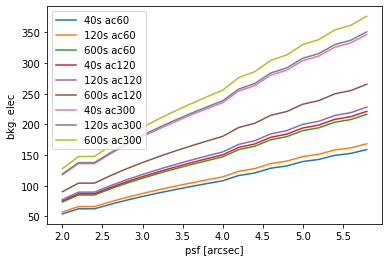

In [19]:
#different accumulations and exposures
getval=lambda dval:getattr(dval,'n',dval)
texpos=[40,120,600]
from matplotlib import pyplot as pl
#gsense_4040.exposure=100
compa=[]
for ac in [60,120,300]: #accumulation
    for b in [25]:#,22,23,24,25]:
        for ex in texpos:
            gsense_4040.exposure=ex/float(ac)
            pep,rep=[],[]
            bkg=[extsource(b)]
            gtrack=0
            for i in range(20):
                modelA.psf=2+i*0.2
                pep.append(2+i*0.2)
                rep.append(gsense_4040.psfnoise(bkg,accum=ac))
            pl.plot(pep,[getval(r) for r in rep],label=f'{ex}s ac{ac}')
            compa.append(np.array([getval(r) for r in rep]))
pl.xlabel("psf [arcsec]")
pl.ylabel("bkg. elec")
leg=pl.legend()

now calculate limiting magnitude estimates using bkg. galaxy with 25 mag./square arcsec, wanting 5 $\sigma$ detection

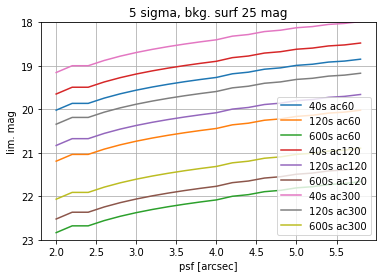

In [124]:
nsig=5
band=0
tele=modelA
ex1=source(21)
efsurf=tele.effective()*tele.reflectivity(band)
for i,a in enumerate(compa):
    pl.plot(pep,ex1.invert(a*nsig/texpos[i%3],efsurf.n))
    b=quads(1/nsig**2,-1,-a**2)
    pl.plot(pep,ex1.invert(b/texpos[i%3],efsurf.n))
pl.ylim(23,18)
pl.xlabel("psf [arcsec]")
pl.ylabel("lim. mag")
pl.title(f'{nsig} sigma, bkg. surf 25 mag')
#(np.array([getval(r) for r in rep])*nsig/100)
pl.legend([t.get_text() for t in leg.get_texts()])
pl.grid()

Cell aboves gives a solution for source electron count $e_s$ from equation

$$\sigma=\frac{e_s}{\sqrt{e_s+e_b+r_o^2}}$$

$e_b$ is background "electrons", $r_o$ is readout RMS.

This is true if we subtract background as some 2-D interpolation (small gaussian uncertainty); if pre-measured $e_b$ is subtracted (with Poissonian noise), the denominator reads $\sqrt{e_s+2\ e_b+r_o^2}$.

**Magnitude error** is directly related to (inverse) signal-to-noise ratio 
$$\Delta m = 1.086 \frac{\mathrm{Noise}}{\mathrm{Sig}}  = 1.086 \frac{\sqrt{\left[(F(m_b)+Z)\ \Omega\ S_{e} + F(m_s)\ S_{e} + DN\right]T + R_o^2\frac{T}{\tau} N} }{F(m_s)\ S_{e}T}$$

where 

- $S_{e}$ is effective surface (incl. quantum efficiency, so photons are converted to photoelectrons)
- $\tau$ is read-out time (period), $R_o$ is read-out noise (RMS)
- $\Omega=N\ \phi^2$ is angular surface of $N$ pixels involved (nb. of pixels to be included in magnitude estimation depends on effective PSF
- $D$ is dark current (e/s) of 1 pixel
- $Z$ is zodiacal light density (using some sky-average value)

$F(m_s)$ and $F(m_b)$ are fluxes for source and flux densities (/arcsec${}^2$) for background, respectively, following the formula

$$F(m)=10^{2/5\ (m_0-m)} F_0$$ with convenient zeropoint magnitude $m_0$ (depending on spectral region).

From that (bringing exposure time to the left side) 
$$q^2\ T \Delta m^2= \frac{\left[(F(m_b)+Z)\ \phi^2\ S_{e} + D + \frac{R_o^2}{\tau} \right] N + F(m_s)\ S_{e}}{F(m_s)^2\ S_e^2}$$

$q=\ln(10)\ 0.4 = 1/1.086$

Solving for $S_e$ is a quadratic equation with

$$a=q^2\ F(m_s)^2 T \Delta m^2$$
$$b= [(F(m_b)+Z)\ \phi^2\ N]+ F(m_s)$$
$$c= (D + \frac{R_o^2}{\tau})\ N$$

In [16]:
srb=source(22)
q=np.log(10)*0.4
delta=0.2
tele=modelA
band=1
efsurface=tele.effective()*tele.reflectivity(band)
srb.photrate(efsurface),efsurface
det.elecount(srb).n,srb.photrate(efsurface)

(2.3425891448191614, 0.9583215514352043+/-0.022286547707795448)

In [338]:
srb.photrate(nrsurf)*det.get_sens(1)
#srb.photrate
gsense_4040.exposure

1

In [315]:
(det.psfnoise([srb,bga])/det.elecrate(srb)/delta/q)**2

6036.537004701536+/-268.11965788675917

In [18]:
det=gsense_4040
bga=extsource(23)
quads=lambda a,b,c:(np.sqrt(b**2-4*a*c)-b)/2/a

#srb.photrate(efsurface),gsense_4040.elecount(srb)
#quads2=lambda a,b,c:(-np.sqrt(b**2-4*a*c)-b)/2/a
def calc_surface(delta,expos=120,sr_mag=21,npix=4,integ=4,band=1):
    '''delta=noise/signal
    returns eff. surface in cm^2
    '''
    srb=source(sr_mag)
    pixnoise=det.darkrate*npix+det.readout**2*npix/integ
    qe=det.get_sens(band)
    ind2=[0,-det.angsize()**2*bga.photrate(surface=1)*npix*qe,-pixnoise]
    ind2[0]=(delta*srb.photrate(surface=1)*qe)**2*expos
    ind2[1]+=srb.photrate(surface=1)*qe
    return quads(*ind2)*1e4
calc_surface(0.1,npix=4),calc_surface(0.1,npix=9,expos=300)

(1167.4988326985106, 1180.2083000795164)

## import STM

In [62]:
import pandas as pd
cols=[0,1,2]+list(range(3,11,2))+[11,13,14,16]+list(range(17,28,2))
fultab=pd.read_excel("/home/limu/Documents/Space/QUVIK/Science/STM_combined.xlsx",usecols=cols,skiprows=[1])
ql=[a for a in fultab.mag_max if a!=float('nan')]#pd.NaN]
#type(ql[1])
zoo=np.array(ql).astype(float)
zsel=np.isnan(zoo)==False
zoo[zsel]#fultab.mag_max

array([22., 17., 17., 17., 17., 17., 19., 19., 19., 20., 21., 21., 21.,
       23., 23., 24.])

In [63]:
fultab.columns

Index(['ON', 'WG', 'Objective', 'PSF', 'FOV', 'PhotPrecision', 'ObsLatency',
       'ObsDuration', 'band1', 'band2', 'mag_min', 'mag_max', 'S2N',
       'PhotAccuracy', 'ObsStrategy', 'target rate', 'img_rate'],
      dtype='object')

In [20]:
prec=fultab.PhotPrecision.to_numpy()
prec2=1/fultab.S2N.to_numpy()
nsel=(np.isnan(prec2)==False)
prec[nsel]=prec2[nsel]

expo=fultab.ObsDuration.to_numpy()
expo2=fultab.ObsLatency.to_numpy()
nsel=np.isnan(expo)*(np.isnan(expo2)==False)
expo[nsel]=expo2[nsel]

In [54]:
#(np.sqrt(nois)/(srb.photrate(surface=nrsurf)*prec[10]*q))**2/3600
source(17).photrate(surface=nrsurf)*1e-3,source(22).photrate(surface=nrsurf)*0.2

(0.04609505174982449, 0.092190103499649)

In [67]:
nsel=np.isnan(prec)==False
pos=np.where(nsel*zsel)[0]
#expos=fultab.ObsLatency
surfs=[]
surfg=[]
limex=[]
integ=10
npix=4
nrsurf=0.0200 #normalized surface
qe=det.get_sens(1) #already included in nrsurf
for i in pos:
    surfs.append(int(calc_surface(delta=prec[i],expos=expo[i]*60,sr_mag=zoo[i],npix=4,integ=integ)))
    surfg.append(int(calc_surface(delta=prec[i],expos=1,sr_mag=zoo[i],npix=4,integ=1)))
    nois=(det.darkrate*npix+det.readout**2*npix/integ)
    nois+=det.angsize()**2*bga.photrate(surface=nrsurf)*npix
    src=source(zoo[i])
    nois+=src.photrate(surface=nrsurf)
    limex.append(nois/(src.photrate(surface=nrsurf)*prec[i]*q)**2/60)
limex=(np.array(limex)*10).astype('int')/10

In [71]:
obje,wg=fultab.Objective[pos],fultab.WG[pos]
repe=(fultab.img_rate[pos].to_numpy()*16).astype(int)
repe[repe<0]=0
outab={'group':wg,'objective':obje,'magnitude':zoo[pos],'surf_1s':surfg,'opt_expo':expo[pos],'repeat':repe,'expo_200cm':limex,'opt_surf':surfs}
outab['band1']=fultab.band1[pos]
outab['band2']=fultab.band2[pos]
outframe=pd.DataFrame(data=outab)
outframe

,group,objective,magnitude,surf_1s,opt_expo,repeat,expo_200cm,opt_surf,band1,band2
0,KN,kilonovae detection,22.0,40438,60.0,16,17.2,179,200-260,260-400
2,ST,BA star surface,17.0,529,5.0,288,490.8,54,both needed,NaN
4,ST,peculiar warps,17.0,529,1.0,1440,490.8,54,"both needed, UV prefer",NaN
5,ST,wind instabil,17.0,529,0.5,2880,490.8,54,"both needed, UV prefer",NaN
8,ST,cool SG loss,17.0,526,60.0,1,4.9,25,both needed,NaN
9,ST,pulsating models,17.0,529,5.0,288,490.8,54,"both needed, UV",NaN
10,AG,disc model,19.0,3652,5.0,1,210.3,355,both needed,NaN
11,AG,TDE physics,19.0,3652,5.0,1,210.3,355,NaN,NaN
12,AG,change look,19.0,3652,5.0,1,210.3,355,-300,NaN
13,BN,symbiotic stats,20.0,10959,30.0,0,229.7,565,any,NaN


In [72]:
outframe.to_excel("/home/limu/Documents/Space/QUVIK/Science/Science_requirem.xlsx")

In [184]:
wsel=(fultab.WG=='ST')
too=fultab.ObsStrategy=='ToO'
sum(too)

7

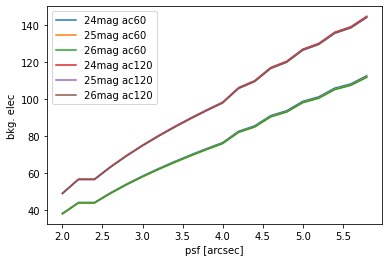

In [125]:
#different accumulations and exposures
getval=lambda dval:getattr(dval,'n',dval)
texpos=[120]
from matplotlib import pyplot as pl
#gsense_4040.exposure=100
compa=[]
for ac in [60,120]: #accumulation
    for b in [24,25,26]:#,22,23,24,25]:
        for ex in texpos:
            gsense_4040.exposure=ex/float(ac)
            pep,rep=[],[]
            bkg=[extsource(b)]
            gtrack=0
            for i in range(20):
                modelA.psf=2+i*0.2
                pep.append(2+i*0.2)
                rep.append(gsense_4040.psfnoise(bkg,accum=ac))
            pl.plot(pep,[getval(r) for r in rep],label=f'{b}mag ac{ac}')
            compa.append(np.array([getval(r) for r in rep]))
pl.xlabel("psf [arcsec]")
pl.ylabel("bkg. elec")
leg=pl.legend()

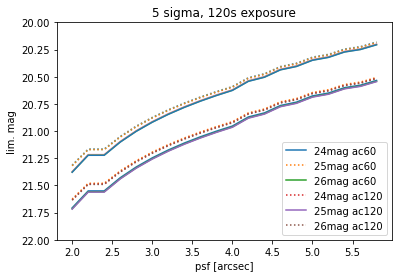

In [102]:
nsig=5
band=0
tele=modelA
ex1=source(21)
efsurf=tele.effective()*tele.reflectivity(band)
for i,a in enumerate(compa):
    b=quads(1/nsig**2,-1,-a**2)
    pl.plot(pep,ex1.invert(a*nsig/texpos[0],efsurf.n))
    pl.plot(pep,ex1.invert(b/texpos[0],efsurf.n),':')
pl.ylim(22,20)
pl.xlabel("psf [arcsec]")
pl.ylabel("lim. mag")
pl.title(f'{nsig} sigma, 120s exposure')
#(np.array([getval(r) for r in rep])*nsig/100)
pl.legend([t.get_text() for t in leg.get_texts()])

In [9]:
#some play with straylights
gsense_4040.darkrate=0.3
modelA.external['zodiac']=1 #1 phot/sec/telescope
gsense_4040.pixnoise()

2.4211580267459185

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

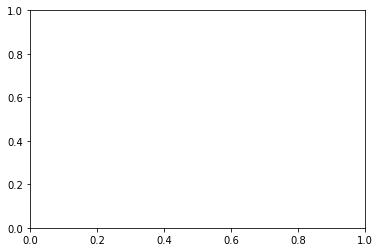

In [21]:
tele=modelA
band=0
tele.external['zodiac']=0.6
#different accumulations and exposures
getval=lambda dval:getattr(dval,'n',dval)
efsurf=tele.effective()*tele.reflectivity(band)
quads=lambda a,b,c:(np.sqrt(b**2-4*a*c)-b)/2/a

def plot_set(bkmags=[25],texpos=[10,40,120],nsig=5):
    ex1=source(21)
    from matplotlib import pyplot as pl
    #gsense_4040.exposure=100
    compa=[]
    for ac in [10,30]: #accumulation
        for b in bkmags:#,22,23,24,25]:
            for ex in texpos:
                gsense_4040.exposure=ex/float(ac)
                pep,rep=[],[]
                bkg=[extsource(b)]
                gtrack=0
                for i in range(20):
                    modelA.psf=2+i*0.2
                    pep.append(2+i*0.2)
                    rep.append(gsense_4040.psfnoise(bkg,accum=ac))
                #pl.plot(pep,[getval(r) for r in rep],label=f'{ex}s ac{ac}')
                compa.append(np.array([getval(r) for r in rep]))
                vals=[]
                for a in compa:
                    b=quads(1/nsig**2,-1,-a**2)
                    vals.append(ex1.invert(b/ex,efsurf.n))
                pl.plot(pep,vals,label=f'{ex}s ac{ac}')
    pl.ylim(23,18)
    pl.xlabel("psf [arcsec]")
    pl.ylabel("lim. mag")
    pl.title(f'{nsig} sigma, bkg. surf %i mag'%bkmags[0])
    pl.legend()
    pl.grid()
    return compa
out=plot_set([25])

In [20]:
out

[array([13.0947739 , 15.12054247, 15.12054247, 16.90528041, 18.51880684,
        20.00259753, 21.38367623, 22.6808137 , 23.90767683, 25.074583  ,
        26.18954779, 28.28794471, 29.28080458, 31.17179685, 32.07551434,
        33.81056081, 34.6455152 , 36.25778711, 37.03761368, 38.54997055]),
 array([14.48421256, 16.72492804, 16.72492804, 18.69903801, 20.48376984,
        22.12500015, 23.65262007, 25.08739206, 26.44443316, 27.73515548,
        28.96842512, 31.28947528, 32.38768389, 34.47932245, 35.4789301 ,
        37.39807602, 38.32162437, 40.10496856, 40.96753969, 42.64036722]),
 array([17.66287747, 20.39533412, 20.39533412, 22.80267676, 24.97908087,
        26.980491  , 28.84335813, 30.59300119, 32.24785474, 33.82183538,
        35.32575494, 38.15617629, 39.4953947 , 42.04605843, 43.26503719,
        45.60535352, 46.73158122, 48.90629316, 49.95816174, 51.99810334]),
 array([22.11047497, 25.53097735, 25.53097735, 28.54450044, 31.26893357,
        33.7743084 , 36.10625443, 38.29646603

In [ ]:
out=plot_set([23])

In [28]:
class observation():
    def __init__(self,telescope,detector):
        self.tele=telescope
        self.detector=detector
        self.detector.tele=self.tele